# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [152]:
import artm

In [153]:
from matplotlib import pyplot as plt
import seaborn as sbn
%matplotlib inline
sbn.set_style("whitegrid", {'axes.grid' : False})

In [154]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [155]:
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                       batch_size=100)


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [156]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, 'author':1}, num_document_passes=1, seed=-1,
                      cache_theta=True)
# Ваш код


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [157]:
random_seed=1
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)


##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [158]:
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [159]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Smoothing', tau=1e5, topic_names='bcg', class_ids=['text'], 
                                                  dictionary=dictionary))


Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [160]:
model_artm.initialize('dictionary')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [161]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Thin', tau=-1e5, topic_names=topic_names[:-1], 
                                                            class_ids=['text'], dictionary=dictionary))


Выполните еще 15 проходов по коллекции.

In [162]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [163]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=' '),
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=' '),
    print('')
    


sbj0:  его власть александр писать историк имя великий римский знаменитый король церковь реформа средневековый над мысль 
sbj1:  там раз планета земля интересный находиться температура тело открывать маленький обнаруживать образовываться вокруг вода атмосфера 
sbj2:  система чтобы между создавать сложный общий направление простой движение ответ способность трудность переход сложно искусственный 
sbj3:  говорить сторона понятие связанный всегда отвечать лицо представление предмет отличаться концепция опыт меняться восприятие рассматривать 
sbj4:  должный вид появляться каждый вещь любой иной качество мой нельзя особый этап оценка никто очередь 
sbj5:  можно при получать структура материал использовать сделать достаточно свойство элемент огромный пора применение устройство сей 
sbj6:  книга научный написать выходить тема автор фильм массовый абсолютно документ герой брать обращать молодой театр 
sbj7:  сам социальный кто после общество принимать считать степень род социология собственно 

In [164]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=' '),
    tokens = model_artm.score_tracker["top_words_author"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=' '),
    print('')

sbj0:  Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Ольга_Вайнштейн Михаил_Бойцов Алексей_Юдин Игорь_Данилевский Раиса_Кирсанова Владимир_Кантор Елена_Браун Игорь_Курукин Елена_Уханова Екатерина_Болтунова Арчил_Балахванцев 
sbj1:  Елизавета_Бонч-Осмоловская Кирилл_Еськов Сергей_Попов Дмитрий_Титов Николай_Пименов Татьяна_Смоктунович Андрей_Иванцов Зоригто_Намсараев Светлана_Дедыш Александр_Марков Сергей_Наугольных Юлия_Краус Елизавета_Ривкина Наталья_Новикова Александр_Слободкин 
sbj2:  Александр_Поддьяков Дмитрий_Громов Михаил_Пантелеев Владимир_Мележик Варвара_Веденина Даниэль_Сельва Антон_Суворов Михаил_Фейгельман Виталий_Пальчиков Алексей_Котов Кирилл_Зыбин Кристофер_Уиншип Андрей_Шевельков Александра_Скрипченко Андрей_Чабовский 
sbj3:  Виталий_Куренной Сергей_Арутюнов Владимир_Миронов Максим_Кронгауз Алексей_Руткевич Николай_Плотников Павел_Степанцов Дмитрий_Куракин Дмитрий_Иванов Фёдор_Гиренок Татьяна_Котова Михаил_Маяцкий Ирина_Каспэ Андрей_Коротаев Григорий

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [165]:
sbj_topic_labels = ['История', 'Климатология', 'Механика', 'Общение', 'Биология', 'Свойства материалов', 'Исскуство', 'Социология',
                    'Наука', 'Квантовая физика', 'Война в России', 'Ювенология', 'Нейробиология', 'Государства',
                    'Астрономия', 'Данные', 'Группы', 'Философия', 'Лингвистика', 'Социология', 'Технологии', 'Альцгеймер', 
                    'Объекты', 'Математика', 'История России', 'Лингвистика', 'Экономика', 'Генетика', 'Исследования']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [166]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids='author')
print(phi_a.shape)
theta = model_artm.get_theta()
print(theta.shape)

(539, 30)
(30, 1728)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

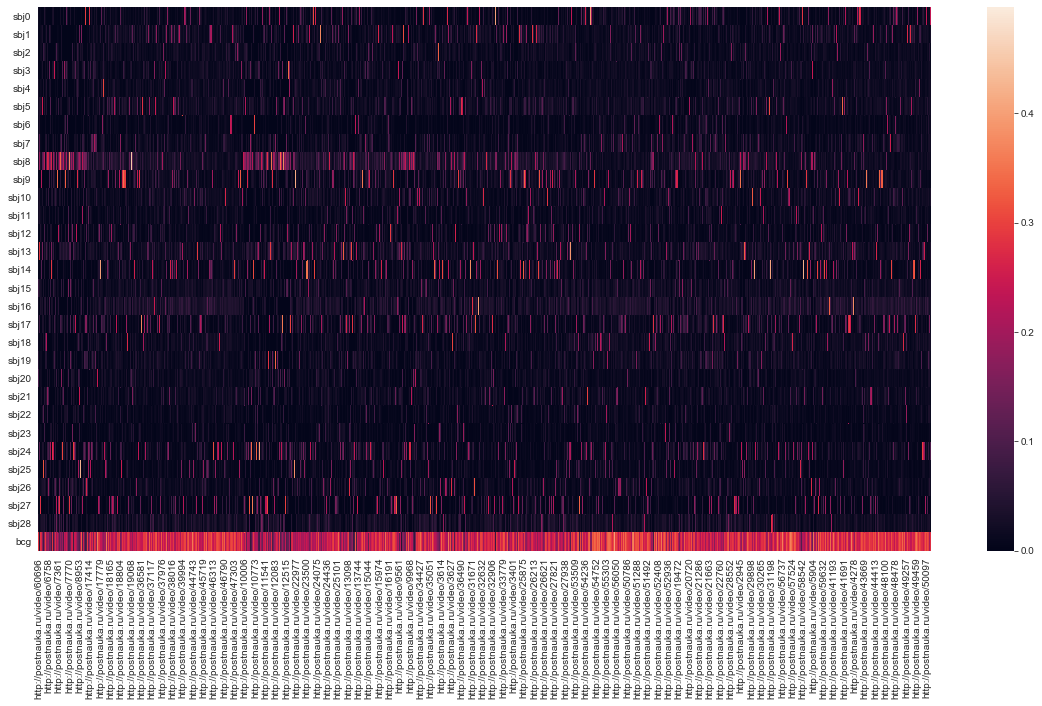

In [167]:
fig, ax = plt.subplots(figsize=(20,10))
sbn.heatmap(theta.head(100))


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [168]:
pt = theta.sum(axis=1)/theta.sum(axis=1).sum()
pt.index = topic_labels

In [169]:
pt.sort_values()

Математика             0.013061
Объекты                0.014102
Исскуство              0.014117
Ювенология             0.017137
Технологии             0.017743
Механика               0.018409
Биология               0.019409
Общение                0.020291
Лингвистика            0.020515
Альцгеймер             0.021492
Нейробиология          0.022012
Социология             0.022032
Лингвистика            0.022124
Социология             0.023263
Война в России         0.024177
Данные                 0.024492
Экономика              0.024497
История                0.027531
Свойства материалов    0.028498
Климатология           0.028677
Исследования           0.028928
Генетика               0.030220
Астрономия             0.032803
Группы                 0.034354
Философия              0.034381
Государства            0.036293
История России         0.036491
Квантовая физика       0.036891
Наука                  0.055328
Фоновая тема           0.250729
dtype: float32

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

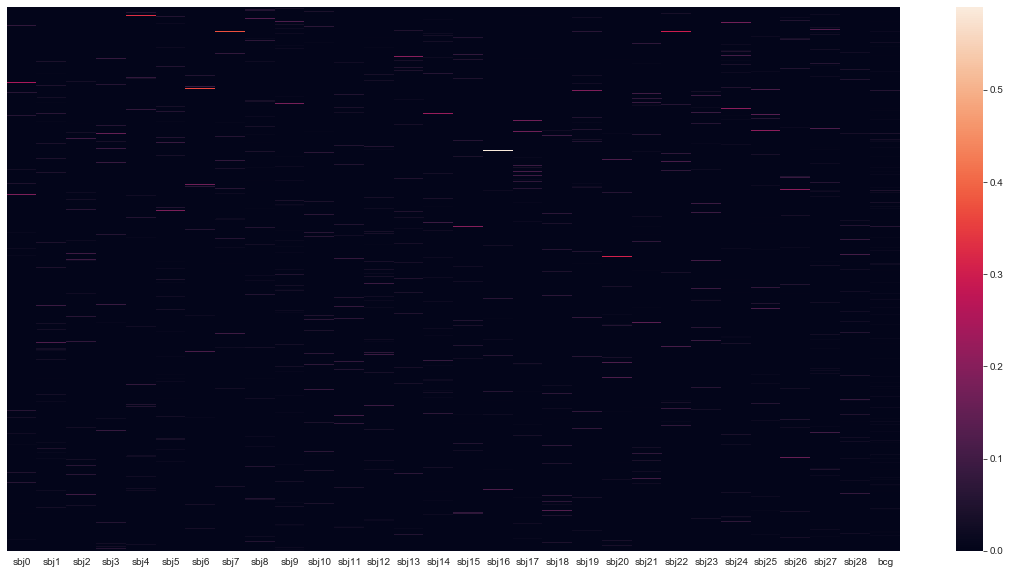

In [170]:
fig, ax = plt.subplots(figsize=(20,10))
sbn.heatmap(phi_a, yticklabels=False)


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [171]:
(phi_a > 0.01).sum(axis=1).sort_values().tail(10)

(author, Владимир_Плунгян)    2
(author, Ирина_Савельева)     2
(author, Михаил_Соколов)      2
(author, Виталий_Куренной)    3
(author, Михаил_Киселев)      3
(author, Елена_Брызгалина)    3
(author, Михаил_Гельфанд)     3
(author, Владимир_Муронец)    3
(author, Михаил_Маяцкий)      3
(author, Виктор_Вахштайн)     4
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [172]:
d = phi_a * pt[1]
d.sum(axis=1)
author_map = d / d.sum(axis=1)[1]

In [173]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [174]:
dist = pairwise_distances(author_map, metric = 'cosine')
mds = MDS(dissimilarity="precomputed")
MDS_transformed_cos = mds.fit_transform(dist)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

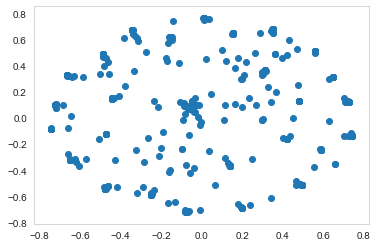

In [175]:
plt.scatter(MDS_transformed_cos[:,0], MDS_transformed_cos[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [176]:
import matplotlib.cm as cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

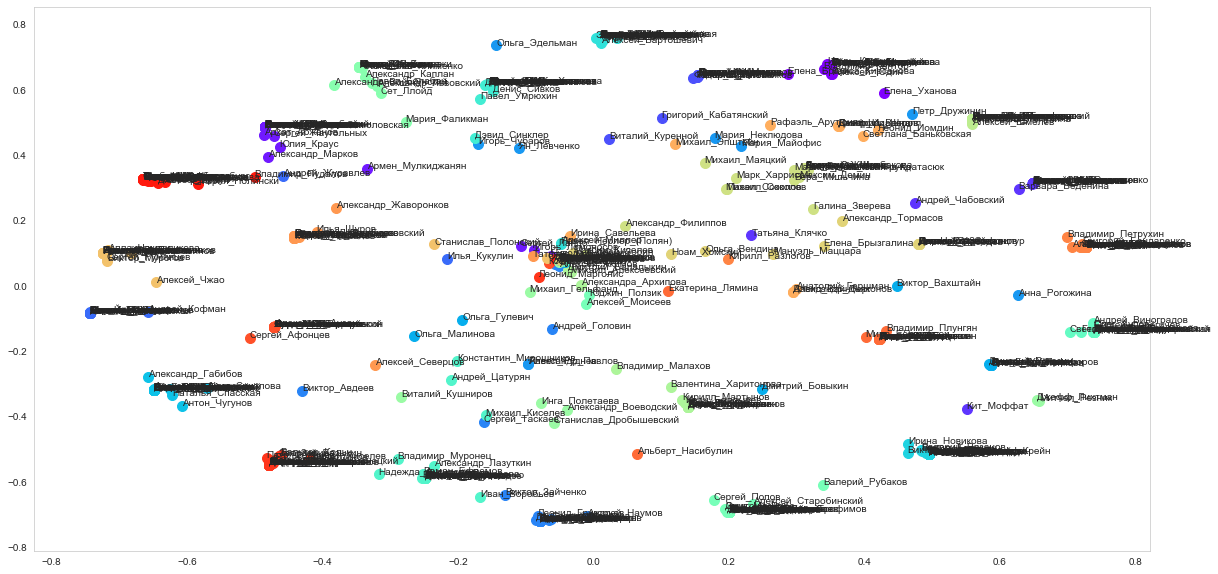

In [177]:
colors = cm.rainbow(np.linspace(0, 1, T))
df = pd.DataFrame(colors, index = phi_a.columns)
fig, ax = plt.subplots(figsize=(20,10))
for i in range(author_map.shape[0]):
    plt.scatter(MDS_transformed_cos[i, 0], 
                MDS_transformed_cos[i, 1], 
                c = df.loc[phi_a.iloc[i,:-1].idxmax(),:].values, s=100)
    plt.annotate(author_map.index[i][-1], xy=[MDS_transformed_cos[i, 0], MDS_transformed_cos[i, 1]])
plt.savefig('map_a.pdf')          

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [178]:
p_dt = theta/theta.sum(axis=1)[-1]
p_dt.head()

,http://postnauka.ru/video/60696,http://postnauka.ru/video/60743,http://postnauka.ru/video/6376,http://postnauka.ru/video/6377,http://postnauka.ru/video/6380,http://postnauka.ru/video/6477,http://postnauka.ru/video/6497,http://postnauka.ru/video/6498,http://postnauka.ru/video/6562,http://postnauka.ru/video/6608,...,http://postnauka.ru/video/50088,http://postnauka.ru/video/50090,http://postnauka.ru/video/50097,http://postnauka.ru/video/50123,http://postnauka.ru/video/50340,http://postnauka.ru/video/50343,http://postnauka.ru/video/50345,http://postnauka.ru/video/50347,http://postnauka.ru/video/50349,http://postnauka.ru/video/50350
sbj0,0.000031,0.000044,0.000000,0.0,0.000000e+00,0.000024,0.00000,0.000009,0.000015,0.000000e+00,...,0.000025,0.000015,0.000547,0.000020,0.000012,0.000041,0.000015,0.000030,0.000013,0.000545
sbj1,0.000082,0.000032,0.000000,0.0,0.000000e+00,0.000030,0.00006,0.000045,0.000085,8.370911e-05,...,0.000061,0.000020,0.000044,0.000059,0.000450,0.000038,0.000033,0.000010,0.000006,0.000055
sbj2,0.000023,0.000038,0.000000,0.0,7.802425e-16,0.000039,0.00000,0.000046,0.000013,1.156151e-17,...,0.000025,0.000035,0.000013,0.000053,0.000057,0.000030,0.000044,0.000111,0.000061,0.000011
sbj3,0.000021,0.000034,0.000000,0.0,1.525886e-04,0.000000,0.00000,0.000023,0.000044,8.491628e-05,...,0.000031,0.000038,0.000039,0.000029,0.000022,0.000042,0.000014,0.000058,0.000035,0.000021
sbj4,0.000035,0.000070,0.000069,0.0,2.285919e-04,0.000036,0.00006,0.000028,0.000033,3.646513e-18,...,0.000043,0.000054,0.000042,0.000024,0.000018,0.000041,0.000055,0.000059,0.000058,0.000039


In [179]:
#Создадим словарь с 10 наиболее релевантных документов по темам
dict_a={}
for i in range(p_dt.shape[0]-1):
    a = p_dt.iloc[i,:].sort_values(ascending=False).head(10)
    dict_a[p_dt.index[i]] = list(a.index)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [180]:
print ("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [181]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [182]:
for i, topic in enumerate(p_dt.index):    
    display(HTML(f"<h2>{topic_labels[i]}</h2>"))   # также <h2>, <h3>
    display(HTML(f"<ul><li>{tokens[topic][:10]}</li></ul>"))
    for j in dict_a[topic]:
        display(HTML(f'<a href={j}">{j}</a>'))


KeyError: 'bcg'

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 